In [1]:
from copy import deepcopy
from subpred.util import load_df
import obonet
import networkx as nx
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np


In [2]:
def get_protein_dataset(
    datasets_folder_path: str,
    organism_ids: set = set(),
    evidence_at_protein_level=True,
    reviewed: bool = True,
):
    df_uniprot = load_df("uniprot", datasets_folder_path)
    if organism_ids:
        df_uniprot = df_uniprot[df_uniprot.organism_id.isin(organism_ids)]
    if evidence_at_protein_level:
        df_uniprot = df_uniprot[df_uniprot.protein_existence == 1]
    if reviewed:
        df_uniprot = df_uniprot[df_uniprot.reviewed]
    return df_uniprot

In [3]:
def get_go_annotations(
    datasets_folder_path: str, proteins: set, include_iea: bool = True
):
    df_goa_uniprot = load_df("go", datasets_folder_path)
    df_goa_uniprot = df_goa_uniprot[df_goa_uniprot.Uniprot.isin(proteins)]
    if not include_iea:
        df_goa_uniprot = df_goa_uniprot[df_goa_uniprot.evidence_code != "IEA"]
    df_goa_uniprot = df_goa_uniprot.reset_index(drop=True)
    return df_goa_uniprot

In [4]:
def add_ancestors(df_uniprot_goa, graph_go):
    df_uniprot_goa = df_uniprot_goa.assign(
        ancestors=[
            nx.descendants(graph_go, go_id) | {go_id} for go_id in df_uniprot_goa.go_id
        ]
    )

    df_uniprot_goa = (
        df_uniprot_goa.explode("ancestors")
        .drop("go_id", axis=1)
        .rename(columns={"ancestors": "go_id"})
        .drop_duplicates()
        .reset_index(drop=True)
    )

    return df_uniprot_goa

In [5]:
def get_id_update_dict(graph, field="alt_id"):
    dict_update_id = dict()
    for node, alt_ids in graph.nodes(data=field):
        if not alt_ids:
            continue
        for alt_id in alt_ids:
            dict_update_id[alt_id] = node

    return dict_update_id


def update_identifiers(
    identifiers: pd.Series, graph: nx.MultiDiGraph, field: str = "alt_id"
):
    dict_update_ids = get_id_update_dict(graph, field=field)
    return identifiers.apply(
        lambda id: dict_update_ids[id] if id in dict_update_ids.keys() else id
    )

In [6]:
def get_filtered_go_graph(
    graph_go: nx.MultiDiGraph,
    root_node: str,
    protein_subset: set,
    inter_go_relations: set = {"is_a"},
    aspects: set = {"molecular_function"},
):
    ## Filter graph by protein dataset
    graph_go = graph_go.subgraph(nodes=protein_subset)
    print(len(graph_go.nodes()))
    ## Filter graph by aspect/namespace
    graph_go = graph_go.subgraph(
        nodes=[
            node
            for node, data in graph_go.nodes(data=True)
            if data["namespace"] in aspects
        ]
    )
    print(len(graph_go.nodes()))

    ## Filter graph by relations
    graph_go = graph_go.edge_subgraph(
        edges={
            edge for edge in graph_go.edges(keys=True) if edge[2] in inter_go_relations
        }
    )
    print(len(graph_go.nodes()))

    ## Filter graph by function
    go_name_to_id = {data["name"]: id for id, data in graph_go.nodes(data=True)}
    tmtp_ancestors = nx.ancestors(graph_go, go_name_to_id[root_node])
    graph_go = graph_go.subgraph(tmtp_ancestors | {go_name_to_id[root_node]})
    print(len(graph_go.nodes()))
    return graph_go.copy()

In [7]:
def get_pairwise_substrate_overlaps(
    dict_chebi_to_uniprot: dict,
    min_overlap: int = 20,
    max_overlap: int = 150,
):
    dict_chebi_to_uniprot_filtered = {
        x: y
        for x, y in dict_chebi_to_uniprot.items()
        if (len(y) >= min_overlap) and (len(y) <= max_overlap)
    }

    ## Calculate protein annotation overlaps for go and chebi, create plot
    sorted_substrate_order = [
        tup[0]
        for tup in sorted(
            [
                (chebi_id, len(proteins))
                for chebi_id, proteins in dict_chebi_to_uniprot_filtered.items()
            ],
            key=lambda x: x[1],
            reverse=True,
        )
    ]
    df_substrate_overlaps = pd.DataFrame(
        0, columns=sorted_substrate_order, index=sorted_substrate_order
    )

    for chebi_id1 in sorted_substrate_order:
        for chebi_id2 in sorted_substrate_order:
            intersection = (
                dict_chebi_to_uniprot_filtered[chebi_id1]
                & dict_chebi_to_uniprot_filtered[chebi_id2]
            )
            overlap = len(intersection)
            df_substrate_overlaps.at[chebi_id1, chebi_id2] = overlap

    return df_substrate_overlaps


In [8]:
def get_go_chebi_mapping(
    datasets_folder_path: str,
    graph_chebi: nx.MultiDiGraph,
    graph_go: nx.MultiDiGraph,
    allowed_relations: set = {"has_primary_input"},
    include_ancestor_chebi_ids=False,
):
    # map the terms of the two graphs to each other, with the allowed relations. If no relation exists then identifier is removed from the mapping
    ## Read go-chebi mapping
    df_go_to_chebi = load_df("go_chebi", datasets_folder_path)

    # update chebi ids
    df_go_to_chebi.chebi_id = update_identifiers(
        identifiers=df_go_to_chebi.chebi_id, graph=graph_chebi
    )

    # update go ids
    df_go_to_chebi.go_id = update_identifiers(
        identifiers=df_go_to_chebi.go_id, graph=graph_go
    )

    ## Filter for primary input substrates:
    df_go_to_chebi = (
        df_go_to_chebi[df_go_to_chebi.relation.isin(allowed_relations)]
        .reset_index(drop=True)
        .drop("relation", axis=1)
    )
    ## Filter by filtered graphs:
    print(df_go_to_chebi.shape[0])
    df_go_to_chebi = df_go_to_chebi[
        df_go_to_chebi.go_id.isin(graph_go.nodes())
    ].reset_index(drop=True)
    print(df_go_to_chebi.shape[0])
    df_go_to_chebi = df_go_to_chebi[
        df_go_to_chebi.chebi_id.isin(graph_chebi.nodes())
    ].reset_index(drop=True)
    print(df_go_to_chebi.shape[0])

    ## Add ancestors
    if include_ancestor_chebi_ids:
        go_chebi_original_chebi_ids = set(df_go_to_chebi.chebi_id)
        df_go_to_chebi = df_go_to_chebi.drop("chebi_term", axis=1)
        df_go_to_chebi.chebi_id = [
            nx.ancestors(graph_chebi, chebi_id) | {chebi_id}
            for chebi_id in df_go_to_chebi.chebi_id
        ]
        df_go_to_chebi = df_go_to_chebi.explode("chebi_id").reset_index(drop=True)
        chebi_id_to_name = {
            id: data["name"] for id, data in graph_chebi.nodes(data=True)
        }
        df_go_to_chebi = df_go_to_chebi[df_go_to_chebi.chebi_id.isin(go_chebi_original_chebi_ids)]  # TODO remove or keep?

        df_go_to_chebi = df_go_to_chebi.assign(
            chebi_term=df_go_to_chebi.chebi_id.map(chebi_id_to_name)
        )

    df_go_to_chebi = df_go_to_chebi.drop_duplicates().reset_index(drop=True)
    return df_go_to_chebi

In [9]:
def create_heatmap(
    df_matrix,
    title: str,
    width: int,
    height: int,
    lower_triangle_only: bool = True,
    annotate_values: bool = True,
    values_format: str = ".0f",
):
    plt.figure(figsize=(width, height))
    plt.title(title)

    mask = np.triu(np.ones_like(df_matrix), k=1) if lower_triangle_only else None
    sns.heatmap(df_matrix, annot=annotate_values, fmt=values_format, mask=mask)


In [10]:
def sort_by_sample_count(annotations:list, annotation_to_samples:dict):
    # sort list of annotations by number of mapped samples
    nodes_to_count = {
        annotation: len(samples)
        for annotation, samples in annotation_to_samples.items()
        if annotation in annotations
    }
    nodes_to_count = sorted(nodes_to_count.items(), key=lambda x: x[1], reverse=True)
    annotations = [y[0] for y in nodes_to_count]
    return annotations

In [11]:
def add_paths_as_edges(graph, nodes_subset, relations_paths: set = {"is_a"}):
    # creates a subset of the graph, and adds an edge if there is a path that uses the relations_path relations between two nodes. 
    # solves the problem caused by creating a subset of a graph that does not contain connecting nodes between two nodes.
    
    # might not include all possible values
    relations_paths_values = {
        "has_functional_parent",
        "has_parent_hydride",
        "has_part",
        "has_role",
        "is_a",
        "is_conjugate_acid_of",
        "is_conjugate_base_of",
        "is_enantiomer_of",
        "is_substituent_group_from",
        "is_tautomer_of",
    }
    # filter graph
    graph_subset = graph.subgraph(nodes_subset).copy()
    # add edges to show relations. edge if there is a path
    graph_relations = graph.edge_subgraph(
        [e for e in graph.edges(keys=True) if e[2] in relations_paths]
    ).copy()

    for node1 in nodes_subset:
        for node2 in nodes_subset:
            if node1 == node2:
                continue
            if nx.has_path(graph_relations, node1, node2) and not nx.has_path(
                graph_subset, node1, node2
            ):
                graph_subset.add_edge(node1, node2)
    return graph_subset

In [12]:
def graph_plot(
    graph_to_plot,
    root_node: str,
    label_name: str = "name",
    # label_count: str = None,
    title: str = "",
    rotation: int = 0,
    # size: tuple = (30, 30),
    width: int = 20,
    height: int = 15,
    undirected_edges:list=None,
    graphviz_layout: str = "neato",
    node_size=10000,
):
    graph_to_plot = graph_to_plot.copy()

    plt.figure(3, figsize=(width, height))

    # progs: "neato", ‘dot’, ‘twopi’, ‘fdp’, ‘sfdp’, ‘circo’, neato
    layout = nx.nx_agraph.graphviz_layout(
        graph_to_plot,
        prog=graphviz_layout,
        root=root_node,
    )

    nx.draw(graph_to_plot, layout, node_size=node_size, node_color="white")

    labels_name_dict = dict(graph_to_plot.nodes(data=label_name))
    text = nx.draw_networkx_labels(
        graph_to_plot, pos=layout, labels=labels_name_dict#, verticalalignment="bottom" # TODO center if no counts 
    )
    for _, t in text.items():
        t.set_rotation(rotation)
        t.set_rotation_mode("anchor")

    # if label_count:
    #     labels_count_dict = dict(graph_to_plot.nodes(data=label_count))
    #     text = nx.draw_networkx_labels(
    #         graph_to_plot, pos=layout, labels=labels_count_dict, verticalalignment="top"
    #     )
    #     for _, t in text.items():
    #         t.set_rotation(rotation)
    #         t.set_rotation_mode("anchor")

    if undirected_edges:
        nodes_set = set(graph_to_plot.nodes())

        undirected_edges = [
            edge
            for edge in undirected_edges
            if (
                edge[0] in nodes_set and edge[1] in nodes_set
            )
        ]
        if len(undirected_edges[0]) > 2:
            graph_to_plot.add_weighted_edges_from(undirected_edges)
        else:
            graph_to_plot.add_edges_from(undirected_edges)
        nx.draw_networkx_edges(
            graph_to_plot,
            layout,
            edgelist=undirected_edges,
            alpha=0.8,
            style="dashed",
            arrows=False,
            edge_color="black",
        )
        if len(undirected_edges[0]) > 2:
            # labels present
            nx.draw_networkx_edge_labels(
                graph_to_plot,
                layout,
                edge_labels={(edge[0], edge[1]): edge[2] for edge in undirected_edges},
                font_color="black",
                alpha=0.8,
            )

    plt.title(title)
    plt.show()

## Main function

In [13]:
# Funtion parameters TODO create function
organism_ids = {83333}
datasets_folder_path = "data/datasets"
go_obo_path = "data/raw/ontologies/go.obo"
chebi_obo_path = "data/raw/ontologies/chebi.obo"


In [14]:
## Get protein dataset for organism
df_uniprot = get_protein_dataset(
    datasets_folder_path=datasets_folder_path,
    organism_ids=organism_ids,
    evidence_at_protein_level=True,
    reviewed=True,
)

In [15]:
graph_go = obonet.read_obo(go_obo_path, ignore_obsolete=True)


In [16]:
df_uniprot_goa = get_go_annotations(
    datasets_folder_path=datasets_folder_path,
    proteins=set(df_uniprot.index.tolist()),
    include_iea=True,
)

In [17]:
# update go ids
df_uniprot_goa.go_id = update_identifiers(df_uniprot_goa.go_id, graph_go)

In [18]:
## Add ancestors to goa, i.e. more abstract terms
df_uniprot_goa = add_ancestors(df_uniprot_goa=df_uniprot_goa, graph_go=graph_go)
print(len(graph_go.nodes()))


43248


In [19]:
# Filtering GO graph
graph_go = get_filtered_go_graph(
    graph_go=graph_go,
    root_node="transmembrane transporter activity",
    protein_subset=set(df_uniprot_goa.go_id.unique()),
    inter_go_relations={"is_a"},
    aspects={"molecular_function"},
)


5826
2424
2424
383


## Filtering Chebi data

In [20]:
# Read chebi ontology
graph_chebi = obonet.read_obo(chebi_obo_path, ignore_obsolete=True)
chebi_id_to_name = {id: data["name"] for id, data in graph_chebi.nodes(data=True)}
chebi_name_to_id = {y: x for x, y in chebi_id_to_name.items()}
## Filter by manually annotated entries
print(len(graph_chebi.nodes()))
graph_chebi = graph_chebi.subgraph(
    [x for x, data in graph_chebi.nodes(data=True) if "3_STAR" in data["subset"]]
)
print(len(graph_chebi.nodes()))

## Filter by substrates

## Add ancestors to get full graph


164519
60547


## GO-Chebi mapping

In [21]:
df_go_to_chebi = get_go_chebi_mapping(
    datasets_folder_path=datasets_folder_path,
    graph_chebi=graph_chebi,
    graph_go=graph_go,
    include_ancestor_chebi_ids=False
)


1996
335
331


## Mapping Uniprot to GO to Chebi

In [22]:
df_uniprot_go_chebi = df_uniprot_goa[["Uniprot", "go_id"]].merge(
    df_go_to_chebi, how="inner", on="go_id"
)

df_uniprot_go_chebi = df_uniprot_go_chebi.drop_duplicates().reset_index(drop=True)
df_uniprot_go_chebi

,Uniprot,go_id,chebi_id,chebi_term
0,A5A627,GO:0015075,CHEBI:24867,monoatomic ion
1,P02920,GO:0015075,CHEBI:24867,monoatomic ion
2,P02921,GO:0015075,CHEBI:24867,monoatomic ion
3,P02930,GO:0015075,CHEBI:24867,monoatomic ion
4,P02931,GO:0015075,CHEBI:24867,monoatomic ion
...,...,...,...,...
2280,P76352,GO:0015230,CHEBI:24040,flavin adenine dinucleotide
2281,P76352,GO:0044610,CHEBI:58210,FMN(3-)
2282,Q59385,GO:0043682,CHEBI:29036,copper(2+)
2283,Q59385,GO:0140581,CHEBI:49552,copper(1+)


In [23]:
dict_chebi_to_uniprot = (
    df_uniprot_go_chebi[["chebi_id", "Uniprot"]]
    .groupby("chebi_id")
    .apply(lambda x: set(x.Uniprot))
    .to_dict()
)

In [24]:
protein_count = df_uniprot_go_chebi.Uniprot.unique().shape[0]
protein_count

331

## Calculating pairwise overlaps for substrates with more then n substrates

In [25]:
df_substrate_overlaps = get_pairwise_substrate_overlaps(
    dict_chebi_to_uniprot=dict_chebi_to_uniprot,
    min_overlap=20,
    max_overlap=protein_count // 2,
)
df_substrate_overlaps.columns = df_substrate_overlaps.columns.map(chebi_id_to_name)
df_substrate_overlaps.index = df_substrate_overlaps.index.map(chebi_id_to_name)
df_substrate_overlaps

,monoatomic ion,monoatomic cation,inorganic cation,organic anion,organic acid,carboxylic acid anion,carbohydrate,proton,chemical entity,amino acid,metal cation,amide,peptide,L-alpha-amino acid zwitterion,carbohydrate derivative,monosaccharide,monocarboxylic acid,inorganic anion
monoatomic ion,121,102,94,21,21,21,19,62,56,10,43,10,8,4,5,7,7,7
monoatomic cation,102,102,94,19,19,19,17,62,56,9,43,9,7,3,5,7,6,5
inorganic cation,94,94,95,18,18,18,16,62,50,9,43,9,7,3,5,7,6,5
organic anion,21,19,18,90,82,80,7,14,17,46,6,6,4,29,6,2,22,3
organic acid,21,19,18,82,82,80,7,14,17,46,6,4,2,29,1,2,22,2
carboxylic acid anion,21,19,18,80,80,80,7,14,17,46,6,4,2,29,1,2,22,2
carbohydrate,19,17,16,7,7,7,69,14,17,0,2,0,0,0,6,25,4,0
proton,62,62,62,14,14,14,14,62,41,6,11,5,5,2,3,6,6,3
chemical entity,56,56,50,17,17,17,17,41,56,8,16,5,4,3,5,7,6,4
amino acid,10,9,9,46,46,46,0,6,8,46,4,2,1,29,0,0,1,1


## Plots

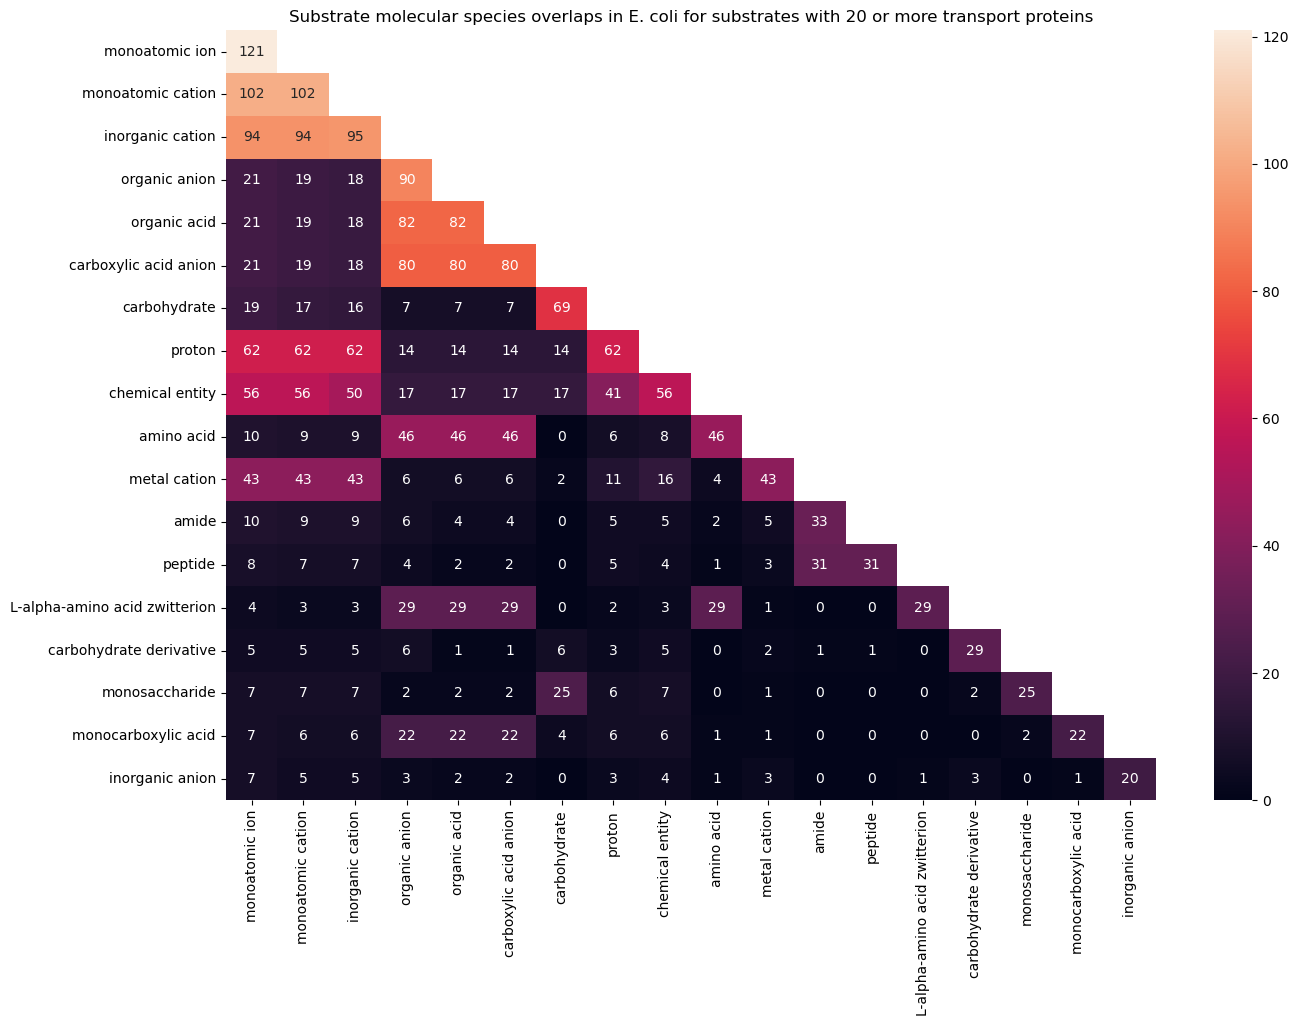

In [26]:
create_heatmap(
    df_matrix=df_substrate_overlaps,
    title="Substrate molecular species overlaps in E. coli for substrates with 20 or more transport proteins",
    width=15,
    height=10,
    lower_triangle_only=True,
)

In [27]:


# sort nodes by number of samples
substrates = df_substrate_overlaps.index.map(chebi_name_to_id)
substrates = sort_by_sample_count(annotations=substrates, annotation_to_samples=dict_chebi_to_uniprot)
graph_chebi_heatmap = add_paths_as_edges(
    graph=graph_chebi, nodes_subset=substrates, relations_paths={"is_a", "is_tautomer_of"}
)

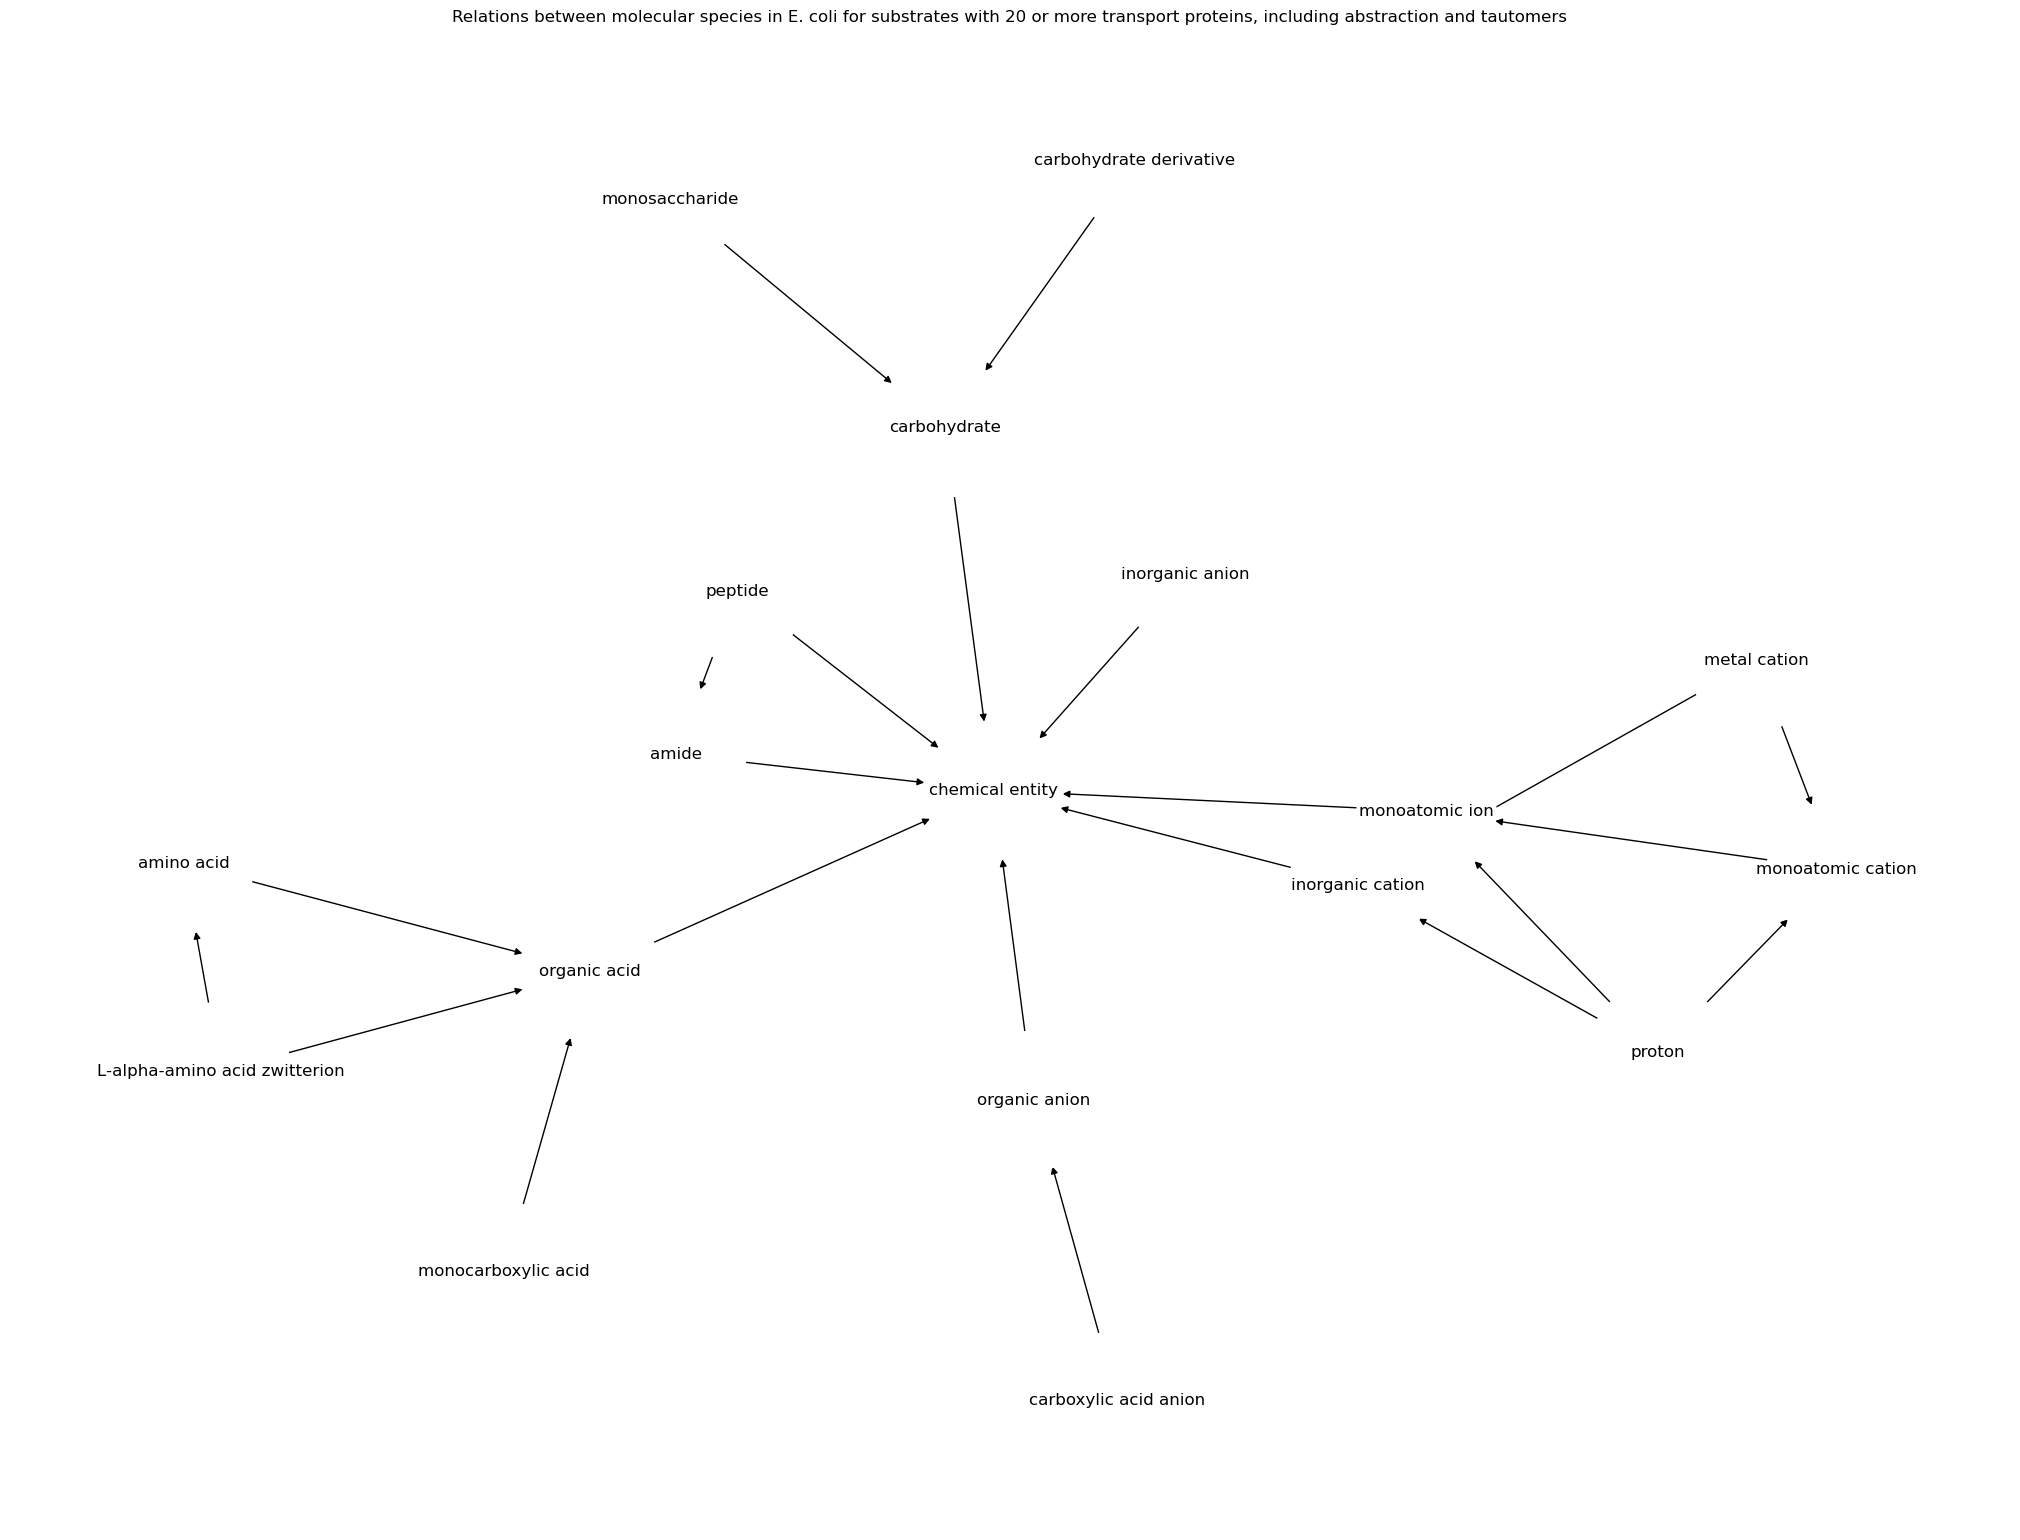

In [28]:
graph_plot(
    graph_chebi_heatmap,
    chebi_name_to_id["chemical entity"],
    title="Relations between molecular species in E. coli for substrates with 20 or more transport proteins, including abstraction and tautomers",
    node_size=10000
)

In [29]:
# Stats and Plots, options for filtering

## create overlap heatmap between substrates

### merge uniprot to go with go to chebi
